In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. Load Data
try:
    # 1A. Load Matches (Standard UTF-8 is usually fine here)
    df_matches = pd.read_csv('data/epl_matches.csv')
    
    # 1B. Load Stadiums (Add encoding='latin-1' to fix UnicodeDecodeError)
    try:
        df_stadiums = pd.read_csv('data/stadiums.csv', encoding='latin-1')
    except:
        # If latin-1 fails, try cp1252
        df_stadiums = pd.read_csv('data/stadiums.csv', encoding='cp1252')

    # 2. Smart Fix for the Date Column
    found_date = False
    possible_names = ['date', 'Match Date', 'MatchDate', 'DATE']
    
    for name in possible_names:
        if name in df_matches.columns:
            print(f"Found date column named: '{name}'. Renaming it to 'Date'...")
            df_matches.rename(columns={name: 'Date'}, inplace=True)
            found_date = True
            break
    
    if not found_date and 'Date' in df_matches.columns:
        print("Found date column named: 'Date'. (Correct)")
        found_date = True
        
    if found_date:
        # Now convert it to datetime format
        df_matches['Date'] = pd.to_datetime(df_matches['Date'])
        print("Files loaded successfully!")
        print(f"Match Data Columns: {list(df_matches.columns)}")
        print(f"Stadium Data Columns: {list(df_stadiums.columns)}")
    else:
        print("ERROR: Could not find a date column! Please check the column names below:")
        print(df_matches.columns.tolist())

except FileNotFoundError:
    print("Error: Files not found. Check if they are in the 'data' folder.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Found date column named: 'MatchDate'. Renaming it to 'Date'...
Files loaded successfully!
Match Data Columns: ['Season', 'Date', 'HomeTeam', 'AwayTeam', 'FullTimeHomeGoals', 'FullTimeAwayGoals', 'FullTimeResult', 'HalfTimeHomeGoals', 'HalfTimeAwayGoals', 'HalfTimeResult', 'HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls', 'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards']
Stadium Data Columns: ['S.No', 'Confederation', 'Stadium', 'City', 'HomeTeams', 'Capacity', 'Country', 'IOC']


In [8]:
# 2. Preprocessing & Smart Column Mapping

# --- PART A: Fix Match Data Columns ---
column_mapping = {
    'FullTimeHomeGoals': 'FTHG',
    'FullTimeAwayGoals': 'FTAG',
    'FullTimeResult': 'FTR'
}
df_matches.rename(columns=column_mapping, inplace=True)

# --- PART B: Fix Stadium Data Columns (Improved) ---
print("--- Columns in Stadiums Dataset ---")
print(df_stadiums.columns.tolist())

# 1. Try to find the exact Team column by name
possible_team_cols = ['Team', 'Team Name', 'Club', 'Name', 'HomeTeam', 'TeamName', 'StadiumTeam']
found_team_col = False

for col in possible_team_cols:
    match = next((x for x in df_stadiums.columns if x.lower() == col.lower()), None)
    if match:
        print(f"Found team column by name: '{match}'. Renaming to 'Team'...")
        df_stadiums.rename(columns={match: 'Team'}, inplace=True)
        found_team_col = True
        break

# 2. If name not found, find the first TEXT column (ignoring numbers/IDs)
if not found_team_col:
    print("WARNING: Could not find 'Team' by name. Searching for text columns...")
    # Get all columns that contain text (strings)
    text_cols = df_stadiums.select_dtypes(include=['object']).columns
    
    if len(text_cols) > 0:
        # Usually the first text column is the Team Name (or Stadium Name)
        # We will assume the first one is correct for now
        best_guess = text_cols[0]
        print(f"Guessing that '{best_guess}' contains the Team names. Renaming to 'Team'.")
        df_stadiums.rename(columns={best_guess: 'Team'}, inplace=True)
        found_team_col = True
    else:
        # Fallback to first column if no text found (rare)
        first_col = df_stadiums.columns[0]
        df_stadiums.rename(columns={first_col: 'Team'}, inplace=True)

# --- PART C: Process & Merge (Safe Mode) ---
try:
    # Select necessary columns
    df = df_matches[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']].copy()
    
    # Feature Engineering
    df['Goal_Diff'] = df['FTHG'] - df['FTAG']
    df['Home_Win'] = (df['FTR'] == 'H').astype(int)
    df['Season'] = df['Date'].dt.year

    # Define Covid Period
    covid_start = pd.Timestamp('2020-03-01')
    covid_end = pd.Timestamp('2021-05-30')
    df['Is_Covid'] = df['Date'].apply(lambda x: 1 if covid_start <= x <= covid_end else 0)

    # CRITICAL FIX: Convert both columns to String (Text) to prevent ValueError
    df['HomeTeam'] = df['HomeTeam'].astype(str).str.strip()
    df_stadiums['Team'] = df_stadiums['Team'].astype(str).str.strip()

    # Merge with Stadium Data
    df_merged = df.merge(df_stadiums, left_on='HomeTeam', right_on='Team', how='left')
    
    print("\n✅ Success! Data processing complete.")
    print(df_merged.head())

except Exception as e:
    print(f"\n❌ ERROR: {e}")

--- Columns in Stadiums Dataset ---
['S.No', 'Confederation', 'Stadium', 'City', 'HomeTeams', 'Capacity', 'Country', 'IOC']
Guessing that 'Confederation' contains the Team names. Renaming to 'Team'.

✅ Success! Data processing complete.
        Date  HomeTeam       AwayTeam  FTHG  FTAG FTR  Goal_Diff  Home_Win  \
0 2000-08-19  Charlton       Man City     4     0   H          4         1   
1 2000-08-19   Chelsea       West Ham     4     2   H          2         1   
2 2000-08-19  Coventry  Middlesbrough     1     3   A         -2         0   
3 2000-08-19     Derby    Southampton     2     2   D          0         0   
4 2000-08-19     Leeds        Everton     2     0   H          2         1   

   Season  Is_Covid  S.No Team Stadium City HomeTeams  Capacity Country  IOC  
0    2000         0   NaN  NaN     NaN  NaN       NaN       NaN     NaN  NaN  
1    2000         0   NaN  NaN     NaN  NaN       NaN       NaN     NaN  NaN  
2    2000         0   NaN  NaN     NaN  NaN       NaN    

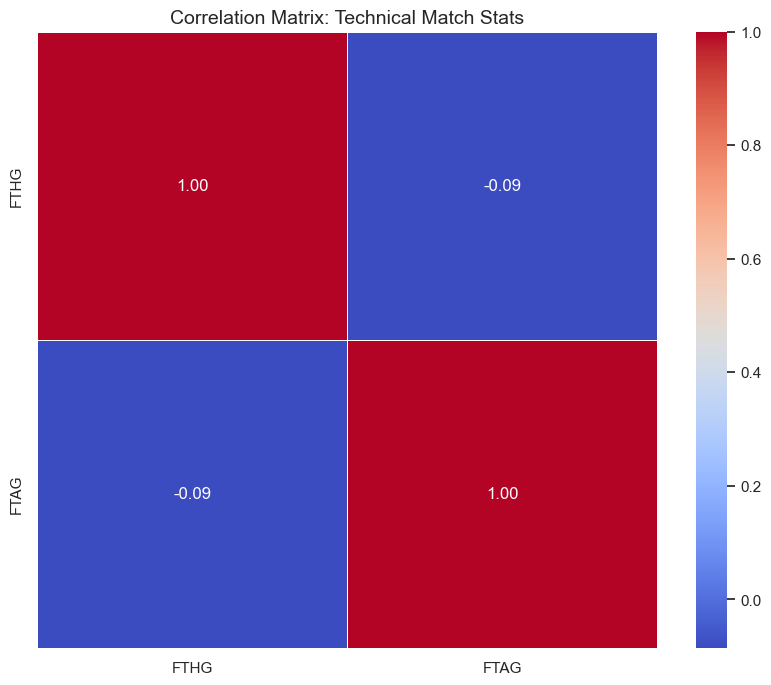

/var/folders/qn/d3vxl2_d2372qfdn2s0sjr800000gn/T/ipykernel_73485/689295607.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=home_advantage.values, y=home_advantage.index, palette='viridis')


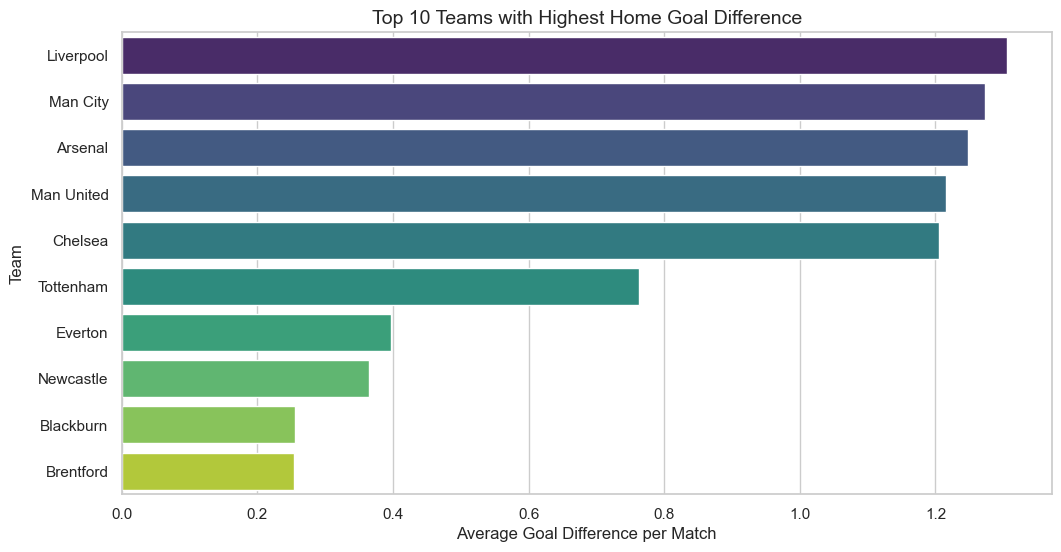

/var/folders/qn/d3vxl2_d2372qfdn2s0sjr800000gn/T/ipykernel_73485/689295607.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Season', y='Goal_Diff', data=df, palette="Set3")


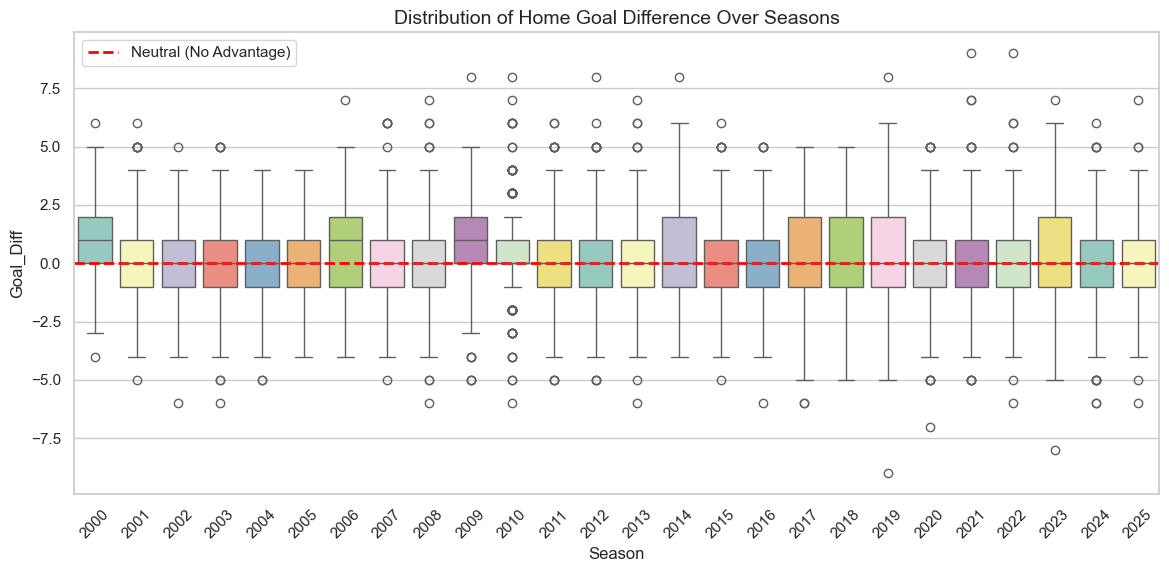

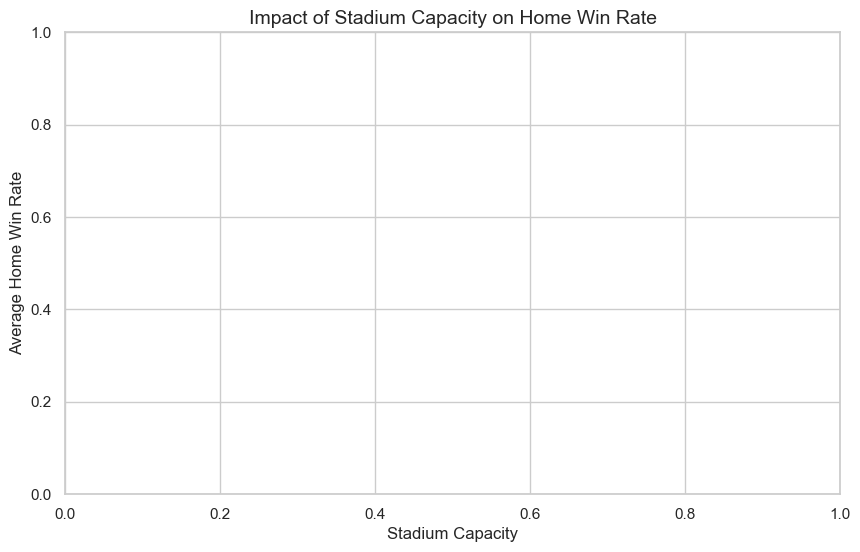

In [9]:
# 3. ADVANCED EXPLORATORY DATA ANALYSIS (EDA)
# In this section, we analyze correlations, team-specific performance, and capacity effects.

sns.set_theme(style="whitegrid")

# --- A. Correlation Matrix (Technical Analysis) ---
# We investigate the relationship between technical match statistics (Shots, Corners, Cards) and Goals.
plt.figure(figsize=(10, 8))

# Select only numeric columns relevant to match statistics
numeric_cols = ['FTHG', 'FTAG', 'HomeShots', 'AwayShots', 'HomeCorners', 'AwayCorners', 'HomeYellowCards', 'AwayYellowCards']
# Filter columns that actually exist in the dataframe to prevent errors
existing_cols = [col for col in numeric_cols if col in df.columns]

if len(existing_cols) > 0:
    corr_matrix = df[existing_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix: Technical Match Stats', fontsize=14)
    plt.show()
else:
    print("Warning: Technical columns (Shots/Corners) not found in dataset. Skipping Heatmap.")

# --- B. Team-Specific Home Advantage (The "Fortress" Effect) ---
# Identify top 10 teams with the highest average Goal Difference at home.
home_advantage = df.groupby('HomeTeam')['Goal_Diff'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=home_advantage.values, y=home_advantage.index, palette='viridis')
plt.title('Top 10 Teams with Highest Home Goal Difference', fontsize=14)
plt.xlabel('Average Goal Difference per Match')
plt.ylabel('Team')
plt.show()

# --- C. Distribution of Home Advantage Over Time ---
# Box plot to visualize the spread and outliers of Goal Difference across seasons.
plt.figure(figsize=(14, 6))
sns.boxplot(x='Season', y='Goal_Diff', data=df, palette="Set3")
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Neutral (No Advantage)')
plt.xticks(rotation=45)
plt.title('Distribution of Home Goal Difference Over Seasons', fontsize=14)
plt.legend()
plt.show()

# --- D. Impact of Stadium Capacity on Home Win Rate ---
# We analyze if larger stadiums (more fans) correlate with a higher win probability.
# Note: We use df_merged here because it contains the 'Capacity' column.
if 'Capacity' in df_merged.columns and 'Home_Win' in df_merged.columns:
    # Group by team to get average capacity and win rate
    capacity_stats = df_merged.groupby('HomeTeam').agg({
        'Capacity': 'mean',
        'Home_Win': 'mean'
    }).reset_index()

    plt.figure(figsize=(10, 6))
    # Scatter plot with regression line
    sns.scatterplot(data=capacity_stats, x='Capacity', y='Home_Win', size='Capacity', sizes=(50, 400), hue='Home_Win', palette='magma')
    sns.regplot(data=capacity_stats, x='Capacity', y='Home_Win', scatter=False, color='black', line_kws={'alpha':0.5})
    
    plt.title('Impact of Stadium Capacity on Home Win Rate', fontsize=14)
    plt.xlabel('Stadium Capacity')
    plt.ylabel('Average Home Win Rate')
    plt.show()
else:
    print("Warning: 'Capacity' column not found. Skipping Scatter Plot.")

In [10]:
# 4. HYPOTHESIS TESTING
# We perform statistical tests to validate the existence of Home Advantage and the impact of COVID-19.

print("--- Hypothesis Test 1: General Home Advantage ---")
# H0: Mean Goal Difference (Home - Away) is <= 0 (No advantage)
# H1: Mean Goal Difference is > 0 (Home advantage exists)

t_stat, p_val = stats.ttest_1samp(df['Goal_Diff'], 0, alternative='greater')

print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_val:.4e}")

if p_val < 0.05:
    print("RESULT: Reject Null Hypothesis (H0). There is a statistically significant Home Advantage.")
else:
    print("RESULT: Fail to reject H0. No significant evidence of Home Advantage.")


print("\n--- Hypothesis Test 2: The 'Ghost Game' Effect (COVID-19) ---")
# H0: Home Win Rate during COVID (No crowds) is equal to or greater than Normal Era.
# H1: Home Win Rate during COVID is significantly LOWER than Normal Era.

# Separate the data into two groups
normal_era = df[df['Is_Covid'] == 0]['Home_Win']
covid_era = df[df['Is_Covid'] == 1]['Home_Win']

# Perform Independent T-Test
t_stat_cov, p_val_cov = stats.ttest_ind(normal_era, covid_era, alternative='greater')

print(f"Normal Era Win Rate: {normal_era.mean():.4f}")
print(f"COVID Era Win Rate:  {covid_era.mean():.4f}")
print(f"P-Value: {p_val_cov:.4f}")

if p_val_cov < 0.05:
    print("RESULT: Reject Null Hypothesis (H0). The Home Advantage significantly DECREASED during COVID-19.")
else:
    print("RESULT: Fail to reject H0. No significant decrease observed.")

--- Hypothesis Test 1: General Home Advantage ---
T-Statistic: 18.8051
P-Value: 9.0290e-78
RESULT: Reject Null Hypothesis (H0). There is a statistically significant Home Advantage.

--- Hypothesis Test 2: The 'Ghost Game' Effect (COVID-19) ---
Normal Era Win Rate: 0.4614
COVID Era Win Rate:  0.4008
P-Value: 0.0046
RESULT: Reject Null Hypothesis (H0). The Home Advantage significantly DECREASED during COVID-19.


In [11]:
# 5. DATA PREPARATION FOR MACHINE LEARNING
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Create a clean dataframe for ML
# We will use Capacity, Covid Status, Season, and Team IDs to predict Home Win
ml_df = df_merged[['HomeTeam', 'AwayTeam', 'Capacity', 'Is_Covid', 'Season', 'Home_Win']].copy()

# Drop rows where Capacity is missing (or fill with mean)
# Filling with mean is safer to keep data
ml_df['Capacity'] = ml_df['Capacity'].fillna(ml_df['Capacity'].mean())

# Encode Team Names into Numbers (e.g., Arsenal -> 0, Chelsea -> 1)
le = LabelEncoder()
all_teams = pd.concat([ml_df['HomeTeam'], ml_df['AwayTeam']]).unique()
le.fit(all_teams)

ml_df['HomeTeam_Code'] = le.transform(ml_df['HomeTeam'])
ml_df['AwayTeam_Code'] = le.transform(ml_df['AwayTeam'])

# Define Features (X) and Target (y)
X = ml_df[['HomeTeam_Code', 'AwayTeam_Code', 'Capacity', 'Is_Covid', 'Season']]
y = ml_df['Home_Win']

# Split data: 80% for Training, 20% for Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")
print("Data is ready for modeling.")

Training Data Shape: (7504, 5)
Testing Data Shape: (1876, 5)
Data is ready for modeling.


Training the model...
Model Accuracy: 58.80%

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.61      0.64      0.63      1013
           1       0.55      0.53      0.54       863

    accuracy                           0.59      1876
   macro avg       0.58      0.58      0.58      1876
weighted avg       0.59      0.59      0.59      1876



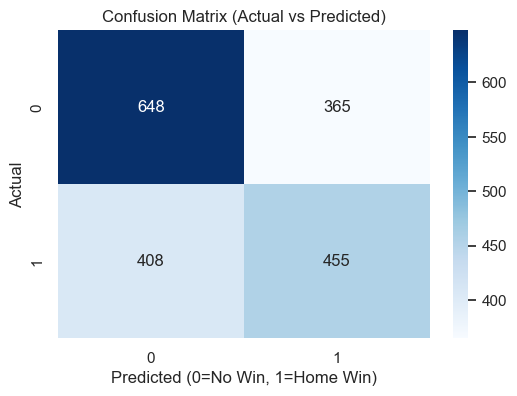

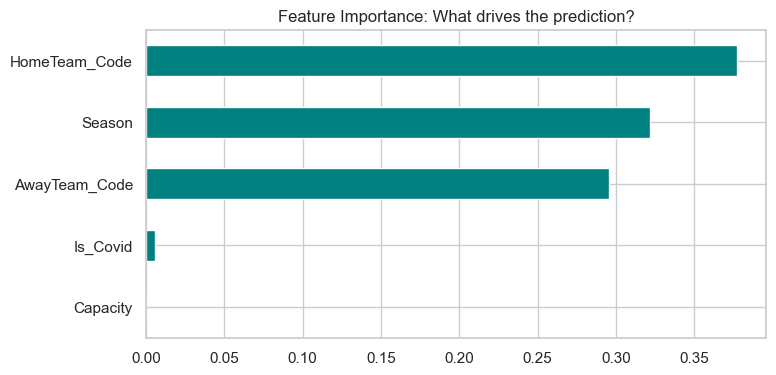

In [12]:
# 6. MACHINE LEARNING: RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
print("Training the model...")
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Actual vs Predicted)')
plt.xlabel('Predicted (0=No Win, 1=Home Win)')
plt.ylabel('Actual')
plt.show()

# Feature Importance (What matters most?)
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
plt.figure(figsize=(8, 4))
feature_importances.sort_values().plot(kind='barh', color='teal')
plt.title('Feature Importance: What drives the prediction?')
plt.show()